In [57]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
%matplotlib inline

def threshold_image(img):
  # RGB color thresholding
  rgb_low = np.array([200, 200, 10])
  rgb_high = np.array([255]*3)
  rgb_binary = cv2.inRange(img, rgb_low, rgb_high).astype(np.bool)
  
  # S channel thresholding
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:, 2]
  s_channel_binary = np.zeros_like(s_channel)
  s_channel_binary[(s_channel >= 150) & (s_channel <= 200)] = 1
  s_channel_binary = s_channel_binary.astype(np.bool)
  
  # Gradient thresholding
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gradient_binary = gradient_threshold(gray)
  
  combined_color = np.zeros_like(img)
  combined_color[rgb_binary, 0] = 255
  combined_color[s_channel_binary, 1] = 255
  combined_color[gradient_binary, 2] = 255

  combined_binary = np.zeros_like(gray)
  combined_binary[rgb_binary | s_channel_binary | gradient_binary] = 255
  return combined_color, combined_binary


def gradient_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
  sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
  sobel_xy *= 255.0 / np.max(sobel_xy)
  sobel_x *= 255.0 / np.max(sobel_x)
  binary = np.zeros_like(gray)
  binary[(sobel_xy >= 40) & (sobel_xy < 100)] = 1
  return binary.astype(np.bool)

def edge_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  binary = cv2.Canny(blur_gray, 50, 100).astype(np.bool)
  return binary
  
def get_perspective_transform(w=1280, h=720):
  """Get perspective transform matrices."""
  src = np.float32([[590, 458], [700, 458], [1156, 714], [267, 714]])
  dst = np.float32([[w*0.25, h*0.2], [w*0.75, h*0.2], [w*0.75, h*0.99], [w*0.25, h*0.99]])
  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)
  return M, Minv

def find_lane_pixels_by_sliding_window(binary_warped):
  """Find lane pixels by sliding window. Copied from Udacity."""
  # Take a histogram of the bottom half of the image
  histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
  # Create an output image to draw on and visualize the result
  out_img = np.dstack((binary_warped, binary_warped, binary_warped))
  # Find the peak of the left and right halves of the histogram
  # These will be the starting point for the left and right lines
  midpoint = np.int(histogram.shape[0]//2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint

  # HYPERPARAMETERS
  # Choose the number of sliding windows
  nwindows = 9
  # Set the width of the windows +/- margin
  margin = 100
  # Set minimum number of pixels found to recenter window
  minpix = 50

  # Set height of windows - based on nwindows above and image shape
  window_height = np.int(binary_warped.shape[0]//nwindows)
  # Identify the x and y positions of all nonzero pixels in the image
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
  # Current positions to be updated later for each window in nwindows
  leftx_current = leftx_base
  rightx_current = rightx_base

  # Create empty lists to receive left and right lane pixel indices
  left_lane_inds = []
  right_lane_inds = []

  # Step through the windows one by one
  for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                  (win_xleft_high,win_y_high),(0,255,0), 2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
                  (win_xright_high,win_y_high),(0,255,0), 2)

    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
      leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
      rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

  # Concatenate the arrays of indices (previously was a list of lists of pixels)
  try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
  except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

  # Extract left and right line pixel positions
  leftx = nonzerox[left_lane_inds]
  lefty = nonzeroy[left_lane_inds]
  rightx = nonzerox[right_lane_inds]
  righty = nonzeroy[right_lane_inds]

  # Visualize lane pixels
  out_img[lefty, leftx] = [255, 0, 0]
  out_img[righty, rightx] = [0, 0, 255]
  return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
  """Fit polynomial lines given lane line pixels."""
  # Find our lane pixels first
  leftx, lefty, rightx, righty, out_img = find_lane_pixels_by_sliding_window(binary_warped)

  # Fit a second order polynomial to each using `np.polyfit`
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)

  # Generate x and y values for plotting
  ploty = np.arange(0, binary_warped.shape[0])
  # ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
  try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty
  left_fitx = left_fitx.astype(np.int32)
  right_fitx = right_fitx.astype(np.int32)

  # Visualize the left and right polynomials on the lane lines
  out_img[ploty, left_fitx] = [255, 255, 0]
  out_img[ploty, right_fitx] = [255, 255, 0]
  #draw_poly(out_img, left_fitx, ploty, (255, 255, 0))
  #draw_poly(out_img, right_fitx, ploty, (255,255, 0))
  return left_fitx, right_fitx, ploty, out_img

def fill_poly(img, left_fitx, right_fitx, ploty, color=(0, 255, 0)):
  left_pts = np.column_stack([left_fitx, ploty])
  right_pts = np.column_stack([right_fitx, ploty])
  pts = np.vstack([left_pts, right_pts[::-1,]])
  cv2.fillPoly(img, [pts], color)

def draw_poly(img, x, y, color=(255, 255, 0), closed=False):
  pts = np.column_stack([x ,y])
  cv2.polylines(img, [pts.reshape(-1, 1, 2)], closed, color)

class Pipeline(object):
  def __init__(self, pickle_fname="camera_calibration.p"):
    cam_cal = pickle.load(open(pickle_fname, "rb"))
    self.mtx = cam_cal["mtx"]
    self.dist = cam_cal["dist"]
    self.M, self.Minv = get_perspective_transform()
    
  def process(self, img):
    # 1. Undistort
    undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)   
    # 2. Thresholding
    threshold_color, threshold_binary = threshold_image(undistorted)
    # 3. Warp
    h, w = img.shape[0], img.shape[1]
    warped = cv2.warpPerspective(undistorted, self.M, (w, h), flags=cv2.INTER_LINEAR)
    warped_color = cv2.warpPerspective(threshold_color, self.M, (w, h), flags=cv2.INTER_LINEAR)
    warped_binary = cv2.warpPerspective(threshold_binary, self.M, (w, h), flags=cv2.INTER_LINEAR)
    # 4. Find lane pixels and fit polynomial lines
    left_fitx, right_fitx, ploty, poly_lines = fit_polynomial(warped_binary)
    lane = np.zeros_like(warped)
    fill_poly(lane, left_fitx, right_fitx, ploty)
    #5. Warp back to original image
    unwarped_lane = cv2.warpPerspective(lane, self.Minv, (w, h), flags=cv2.INTER_LINEAR)
    unwarped = cv2.addWeighted(undistorted, 1, unwarped_lane, 0.3, 0)
    return threshold_color, warped, warped_color, warped_binary, poly_lines, unwarped


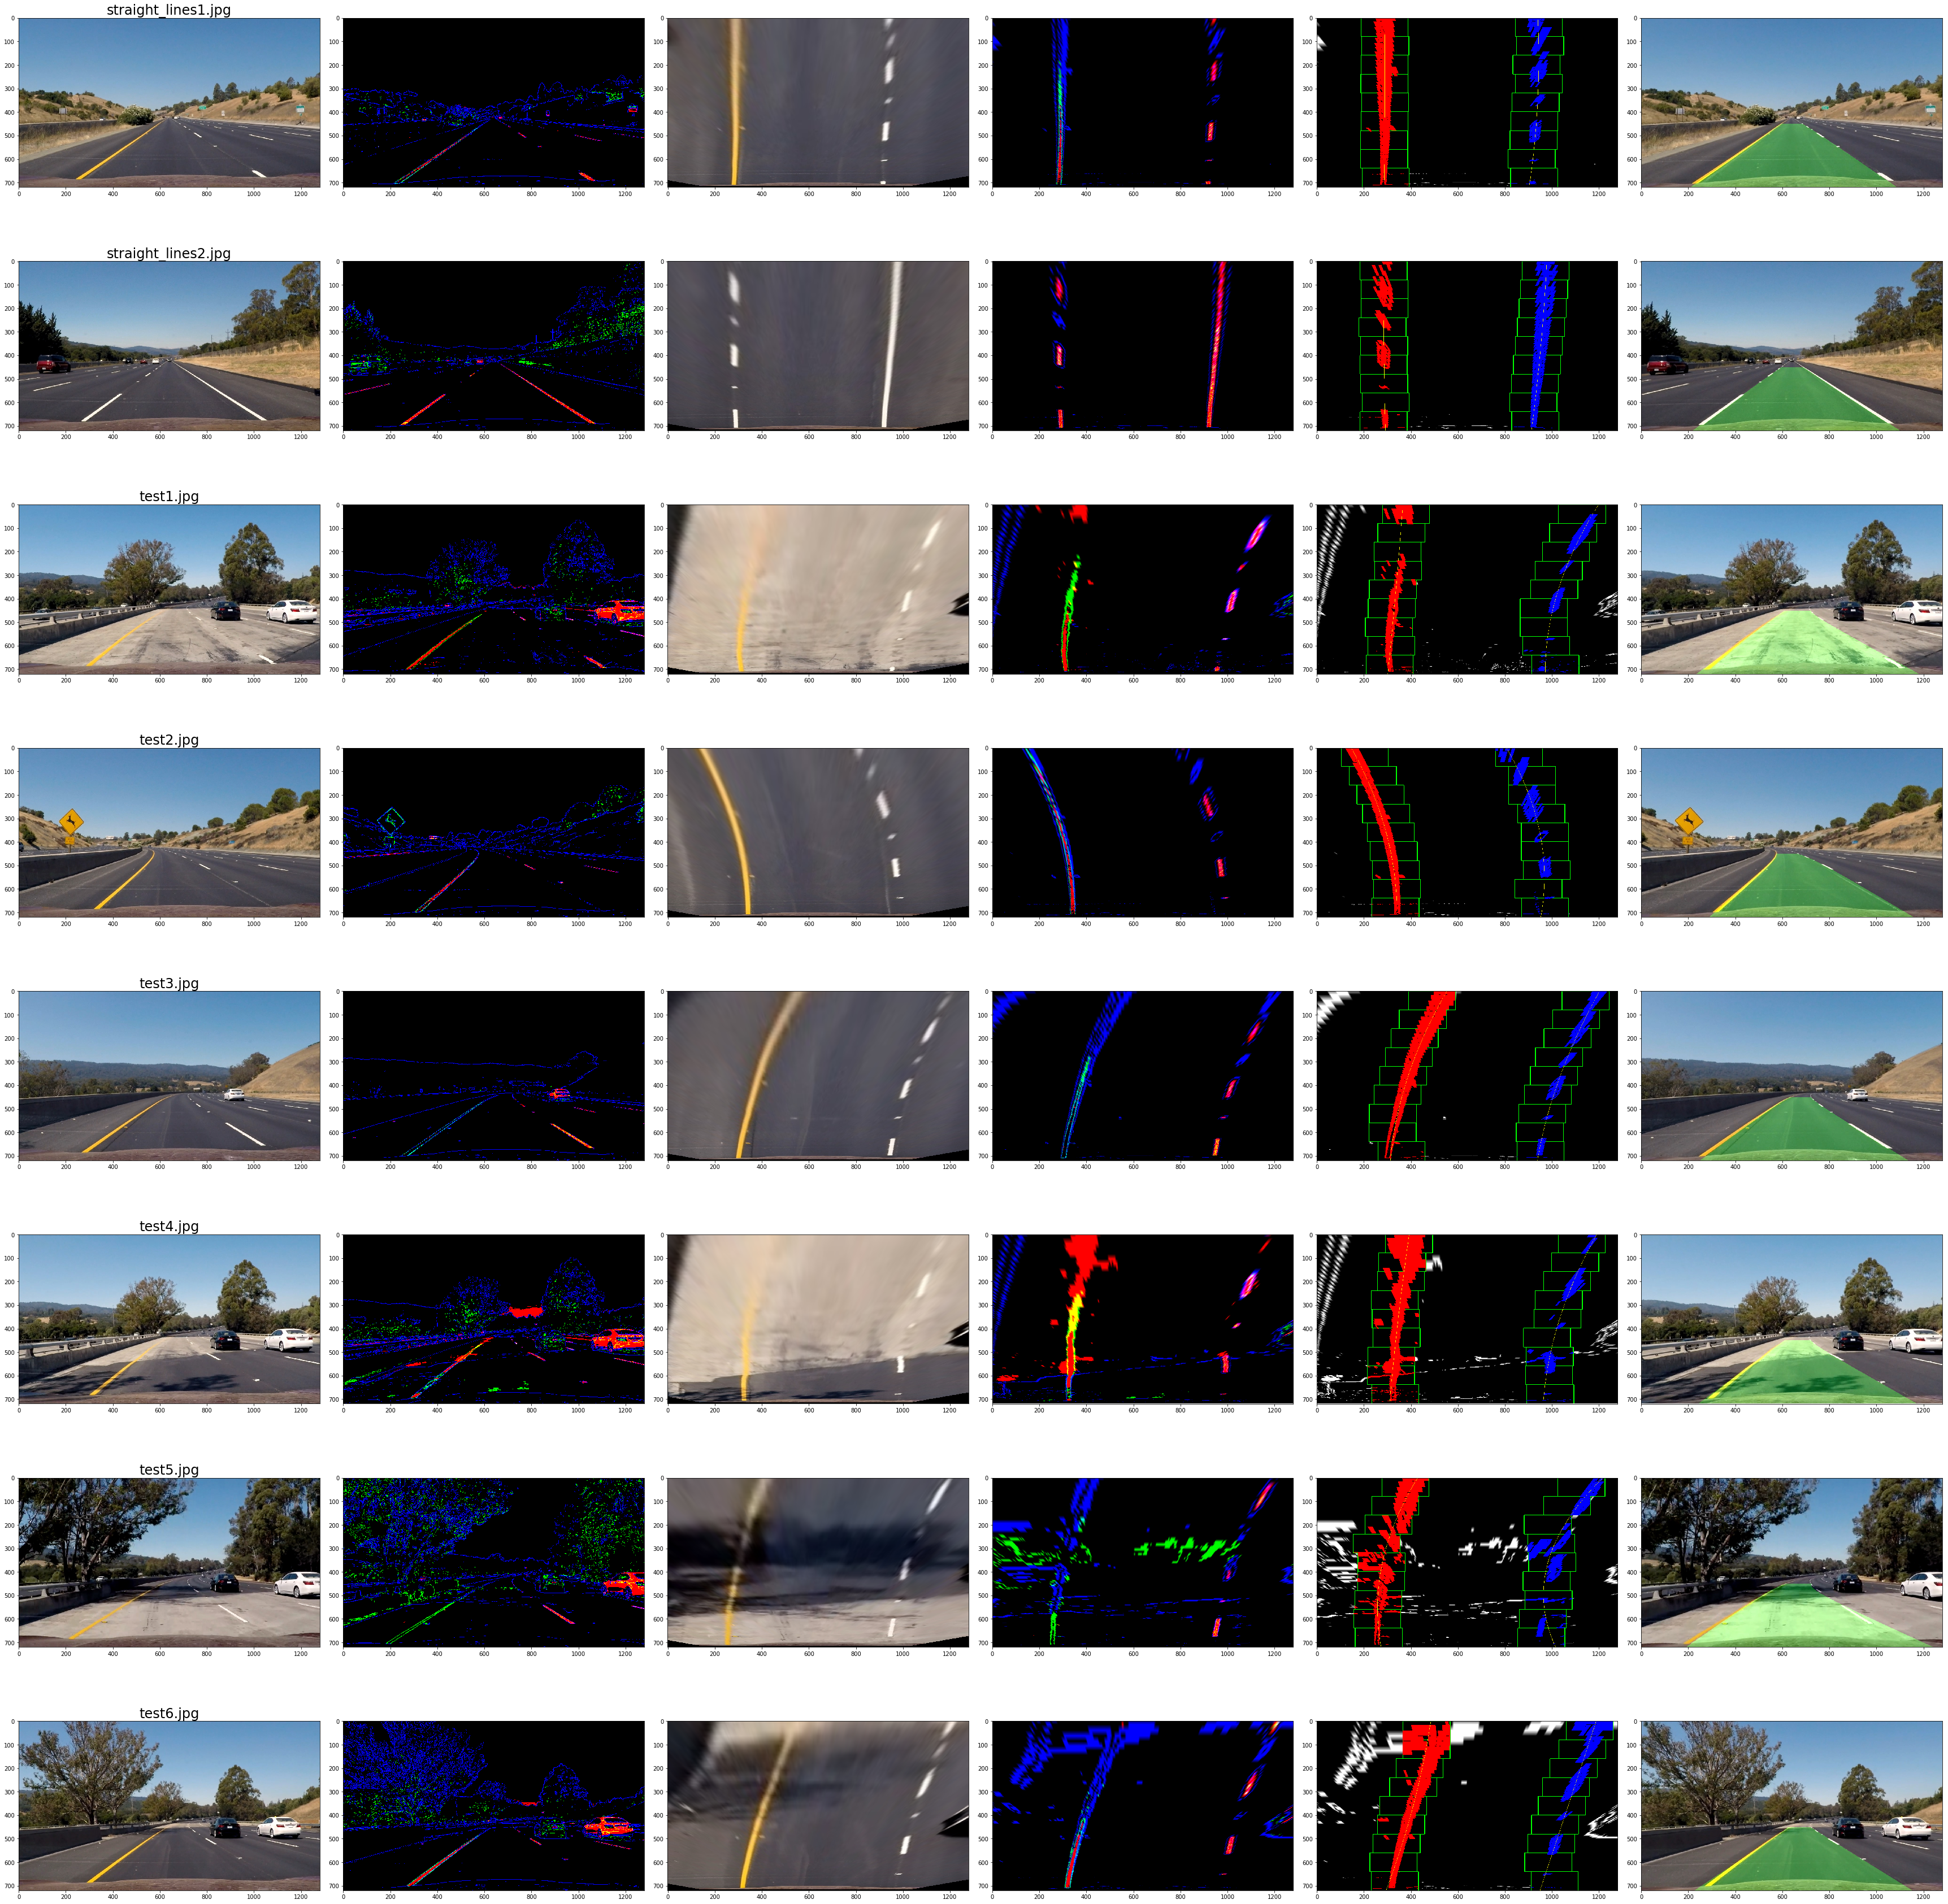

In [56]:
images = glob.glob("test_images/*.jpg")
images.sort()
fig, axes = plt.subplots(len(images), 6, figsize=(8*6, 6*len(images)))
fig.tight_layout()
pipeline = Pipeline()
for i, fname in enumerate(images):
  img = cv2.imread(fname)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  combined_color, combined_binary = threshold_image(img)
  threshold_color, warped, warped_color, warped_binary, poly_lines, unwarped = pipeline.process(img)
  base_name = os.path.basename(fname)[:-4]
  cv2.imwrite("output_images/" + base_name +"_poly.jpg", cv2.cvtColor(poly_lines, cv2.COLOR_RGB2BGR))
  cv2.imwrite("output_images/" + base_name +"_unwarped.jpg", cv2.cvtColor(unwarped, cv2.COLOR_RGB2BGR))
  for j, out_img in enumerate([img, threshold_color, warped, warped_color, poly_lines, unwarped]):
    if len(out_img.shape) == 3:
      axes[i, j].imshow(out_img)
    else:
      axes[i, j].imshow(out_img, cmap='gray')
    axes[i, 0].set_title(base_name, fontsize=24)
